<a href="https://colab.research.google.com/github/frank690/math4ai/blob/main/assignment06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HHU Deep Learning in Life Science: Generative Models, Prof. Dr. Markus Kollmann, SS2022
## Assignment 6 - Generative Adversarial Networks (GANs)

This exercise was created by *Nikolaos Adaloglou* and *Tim Kaiser* for `Deep Learning in Life Science: Generative Models` in 2022

---

This exercise is about implementing and understanding the GAN model from [this](https://arxiv.org/abs/1406.2661) paper. 

### Table of Contents

The notebook contains of the following sections:

1. Preparation and Data Setup
3. GAN Architectures
4. Training
5. Evaluation
6. Questions

Let's start by basic imports and defining the dataset.

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import pylab
import numpy as np

np.random.seed(42)
torch.manual_seed(42);

cuda = torch.cuda.is_available()
print(f"Using GPU: {cuda}")

if cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Using GPU: True


## Part I. Preparation and Data Setup

In [ ]:
# Hyper-parameters
latent_size = 64
G_hidden_size = 512
D_hidden_size = 64
image_size = 784 
batch_size = 128

In [ ]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor()])

# MNIST dataset
train_set = torchvision.datasets.MNIST(root='data',
                                   train=True,
                                   transform=transform,
                                   download=True)

test_set = torchvision.datasets.MNIST(root='data',
                                   train=False,
                                   transform=transform,
                                   download=True)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size, 
                                          shuffle=True)

# input: [bs, 1, 28, 28]
def make_image_grid(images, nrow=8):
    """Helper function for plotting later"""
    images = images.float()  
    grid = torchvision.utils.make_grid(images, nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    return grid

## Part II. GAN Architecture

Important things to note here:

- Real images will be passed to G and D in the range [0, 1].
- The last layer activation of G will be sigmoid, so that they are in the same range.
- The discriminator D does not have a sigmoid activation in our case. Based on your choice of your loss function from Pytorch you can add it here. In the vanilla setup, it is a scalar and training employs binary cross entropy loss.
- From the `print(model)` you can find the sizes of the linear layers.


```
Generator(
  (block): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Discriminator(
  (block): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
```



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features=image_size, out_features=hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=hidden_size, out_features=1)
        )
        
    def forward(self, x):
        return self.block(x)

    
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=image_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.block(x)

G = Generator(64, 28**2, 256)
D = Discriminator(28**2, 256)
print(G)
print(D)

Generator(
  (block): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Discriminator(
  (block): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


## Part III. Training and Sampling

In standard GAN training, the Generator G and Discriminator D are trained simultainiously. Below, the training procedures for both networks is described separately, when implementing it however, some parts overlap.

#### Training G:

- Sample a minibatch of random noise vectors $z$. Do a forward pass with the generator to produce a minibatch of fake images $G(z)$ (here you can reuse $G(z)$ from above, but before you detach it!).
- Do a forward pass through the discriminator using the fake images.
- Calculate the part of the objective, that involves $G$: $\mathbb{E}_{x ~ p_{data}(x)} [\log (1 - D(G(z))]$, via BinaryCrossEntropy loss. 
- Backpropagate and update the generator parameters.
- Keep in mind that the backpropagation also created gradients in D! These were not used, since the optimizer for G only updates G's parameters, but we need to **zero D's gradients after updating G**. 


Here is how **our** implementation looks like:
```
def train_generator(generator, discriminator, g_optimizer, z, criterion):
  """
  generator: nn model
  discriminator: nn model
  g_optimizer: the model optimizer for G
  z: the sampled random noise vector
  criterion: the loss function i.e. nn.CrossEntropy()

  Returns: loss_G: The loss value for this minibatch.
           fake_imgs: The minibatch of generated images.
           pred_fake: Disciminator's output scalars for this minibatch. 
  """

```

There is a handy loss function, called 'BCEWithLogitsLoss' that combines a 'Sigmoid' layer and 'BCELoss' in a single class. This has numerical advantages, because the log and exp cancel. Hence, we don't need a sigmoid layer at the end of D, since it's included in the loss function. 

The image below provides some info you may find useful (ignore the "condition"):

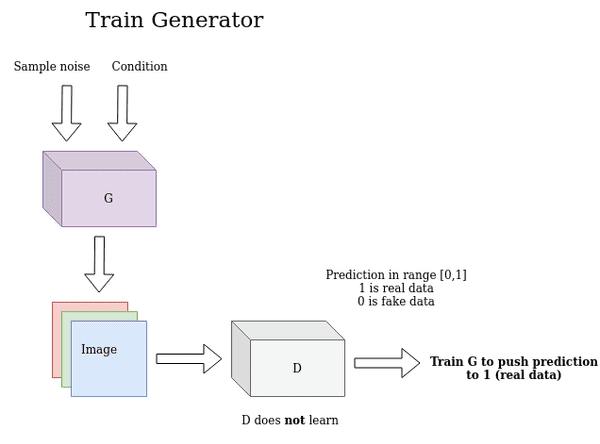



#### Training D:
- Zero D's gradients, because the previous update on G also accumulated gradients in D.
- Obtain a minibatch of real images and their corresponding labels. 
- Do a forward pass by feeding the real images to D.
- Calculate the first part of the loss: $\mathbb{E}_{x ~ p_{data}(x)} [\log D(x)]$, via BinaryCrossEntropy loss.  
- Get a minibatch of fake images $G(z)$ by performing a forward pass of G with standard normal noise $z \sim \mathcal{N}(0,I)$. **Detach the minibatch of fake images**, so that G does not learn in this step.
- Do a forward pass by feeding the fake images to D.
- Calculate the second part of the loss: $\mathbb{E}_{x ~ p_{data}(x)} [\log (1 - D(G(z))]$, via BinaryCrossEntropy loss.
- Calculate the total discriminator loss by adding the two loss terms from above.
- Backpropagate and update the discriminator optimizer parameters. Remeber that this did not change G's parameters!

**Our** implementation of the function `train_discriminator` has the following parameters: 

```
def train_discriminator(discriminator, d_optimizer, real_imgs, fake_imgs, criterion):
  """
  discriminator: the implemented model D
  d_optimizer: the optimizer for D
  real_imgs: a batch of MNIST images
  fake_imgs: a batch of generated images
  criterion: the choice of the loss function i.e. nn.BinaryCrossEntropy()

  Returns: loss_D: The loss value for this minibatch.
           pred_real: Discriminator's output for the real images. 
  """
```

This is only a guideline. Implement the function based on your understanding.

The image below provides some info you may find useful (ignore the "condition"):


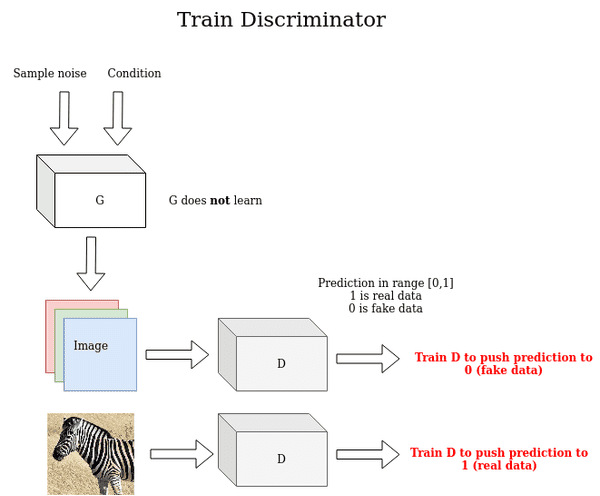

# Implement the whole training scheme of GANs

Your training function needs to print the following information (fits in one line):
* Epoch Number
* G loss
* D loss
* $D(x)$ and $D(G(z))$

Also, plot samples using the test loader at regular intervals (e.g. every 10 epochs).

Your main training function needs to have 'logs' (see below) as an argument. It's a dictionary with four empty lists. Fill these lists with the following information and return them at the end. 

* g_loss_hist: Append the Generator loss after each iteration.
* d_loss_hist: Append the Discriminator loss after each iteration.
* prob_fake_hist: Append the Discriminator output of the fake images, normalized to a probability value, after each iteration.
* prob_fake_real: Append the Discriminator output of the real images, normalized to a probability value, after each iteration. 

To organize your code a bit more, feel free to use the function layout below, this is not mandatory though.

In [ ]:
def train_generator(G, D, g_optimizer, z, criterion):
    """Function to perform one Generator update"""
    fake_imgs = G.forward(z)
    pred_fake = D.forward(fake_imgs)
    labels = torch.ones(z.shape[0], 1).to(device)
    loss = criterion(input=pred_fake, target=labels)
    loss.backward()
    g_optimizer.step()
    
    return loss, fake_imgs, pred_fake

def train_discriminator(D, d_optimizer, real_imgs, fake_imgs, criterion):
    """Function to perform one Discriminator update"""
    d_optimizer.zero_grad()

    pred_real = D.forward(real_imgs)
    labels = torch.ones(real_imgs.shape[0], 1).to(device)
    loss_D_real = criterion(input=pred_real, target=labels)
    
    fake_imgs = fake_imgs.detach()
    pred_fake = D.forward(fake_imgs)
    labels = torch.zeros(fake_imgs.shape[0], 1).to(device)
    loss_D_fake = criterion(input=pred_fake, target=labels)
    
    loss = loss_D_real + loss_D_fake
    loss.backward()
    d_optimizer.step()
    
    return loss, pred_real

In [ ]:
def sample(n, G, latent_size, img_size, plot=False):
    """Function to sample from the test loader, e.g. between epochs."""
    z = torch.randn(n, latent_size).to(device)
    samples = G.forward(z)

    if plot:
        images = samples.detach().cpu().numpy()
        images = images.reshape(n, img_size, img_size)
        
        f, axis = plt.subplots(1,n, sharey=True, figsize=(10,8)) 
        for i, image in enumerate(images):
            axis[i].imshow(image)
        plt.show()
    return samples

def train(epochs, G, D, train_loader, test_loader, g_optimizer, d_optimizer, logs): 
    """Main training function"""
    # we use this function that This loss combines a
    # Sigmoid layer and the BCELoss in one single class. 
    # This version is more numerically stable
    # than using a Sigmoid layer followed by BCELoss 
    latent_size = 64
    img_size = 28
    test_epoch = 10
    
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(train_loader):
            real_imgs = real_imgs.to(device)
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            z = torch.randn(real_imgs.shape[0], latent_size).to(device)
            real_imgs_flat = real_imgs.reshape(-1, img_size**2)
            
            loss_G, fake_imgs, pred_fake = train_generator(G, D, g_optimizer, z, criterion)
            loss_D, pred_real = train_discriminator(D, d_optimizer, real_imgs_flat, fake_imgs, criterion)
            
            logs['g_loss_hist'].append(loss_G.item())
            logs['d_loss_hist'].append(loss_D.item())
            logs['prob_real_hist'].append((torch.sum(pred_real > 0) / pred_real.numel()).item())
            logs['prob_fake_hist'].append((torch.sum(pred_fake <= 0) / pred_fake.numel()).item())
            
        if epoch%test_epoch == 0:
            print(f"{epoch+1}/{epochs}:")
            sample(n=5, G=G, latent_size=latent_size, img_size=img_size, plot=True)
    return logs

# Run training

We use the adam optimizer with `lr=1e-4` for both networks and train for 200 epochs.

In [ ]:
G = Generator(latent_size, image_size, G_hidden_size)
D = Discriminator(image_size, D_hidden_size)

D = D.to(device)
G = G.to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)

logs = {"d_loss_hist": [],
        "g_loss_hist": [],
        "prob_real_hist": [],
        "prob_fake_hist": []}

Run the training. Adjust the function arguments if necessary.

In [ ]:
G_hidden_size

512

In [ ]:
D

Discriminator(
  (block): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
G

Generator(
  (block): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

1/200:


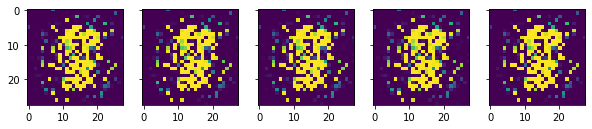

11/200:


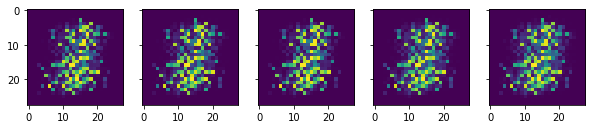

21/200:


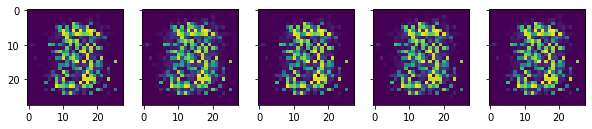

31/200:


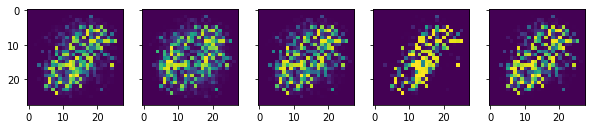

41/200:


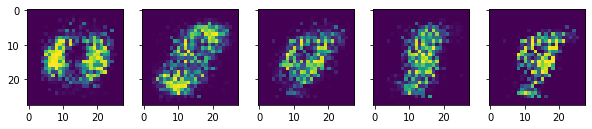

51/200:


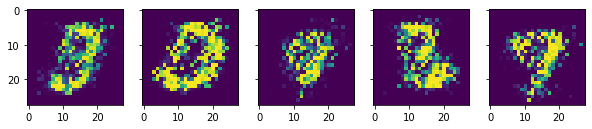

61/200:


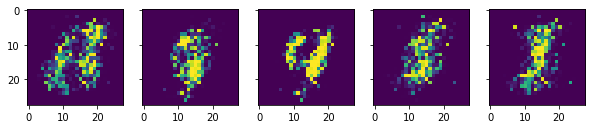

71/200:


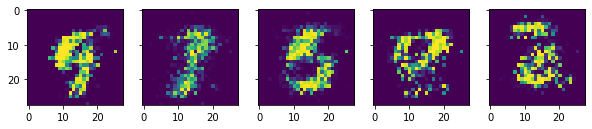

81/200:


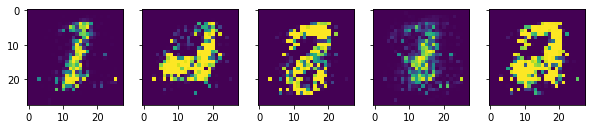

91/200:


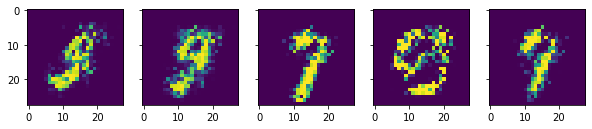

101/200:


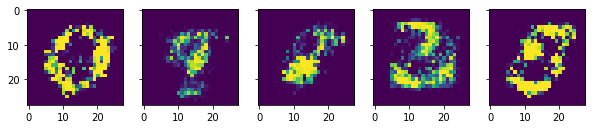

111/200:


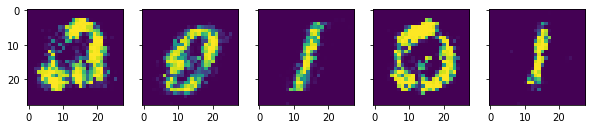

121/200:


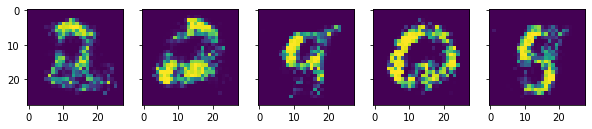

131/200:


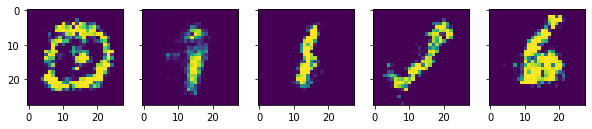

141/200:


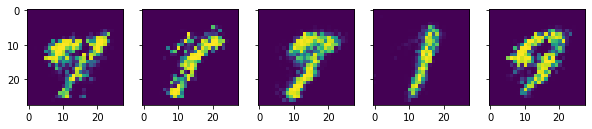

151/200:


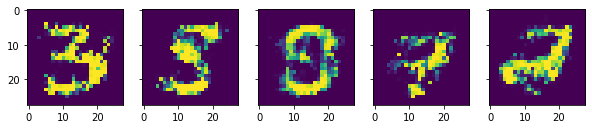

161/200:


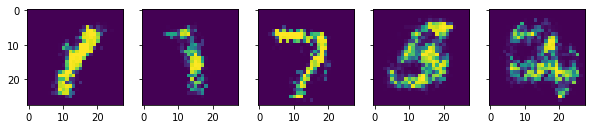

171/200:


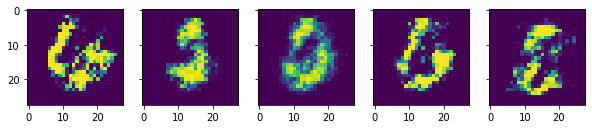

181/200:


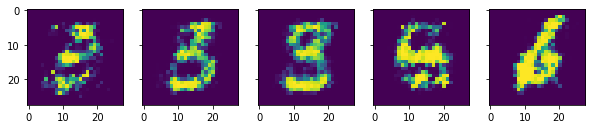

191/200:


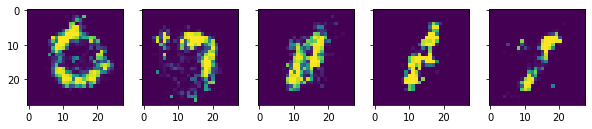

In [ ]:
logs = train(200, G, D, train_loader, test_loader, g_optimizer, d_optimizer, logs)

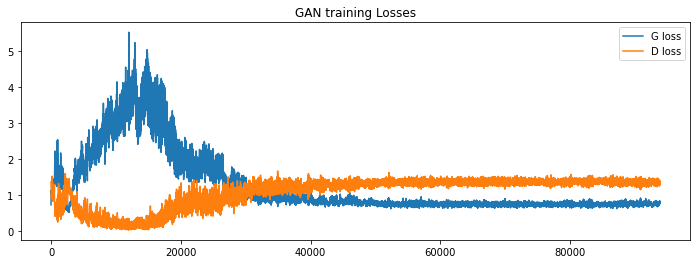

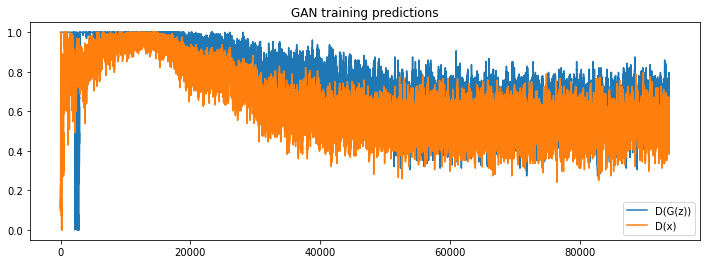

In [ ]:
plt.figure(figsize=(12,4))
plt.title("GAN training Losses")
plt.plot(logs["g_loss_hist"], label='G loss')
plt.plot(logs["d_loss_hist"], label='D loss')    
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(12,4))
plt.title("GAN training predictions")
plt.plot(logs["prob_fake_hist"], label='D(G(z))')
plt.plot(logs["prob_real_hist"], label='D(x)')
plt.legend()
plt.show()
plt.close()

## Part IV. Evaluation

Evaluating the performance of a GAN is difficult, so just plot some samples here.

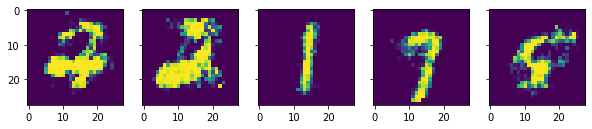

In [ ]:
_ = sample(n=5, G=G, latent_size=latent_size, img_size=28, plot=True)

# Questions

- A stanard diffulty of GAN training is tuning the balance between Generator and Discriminator. How would you balance the training between G and D? What choice influence this balance?

- Is it possible to add more loss terms to the objective in order to improve the training? If so, can you think of loss terms to add here? What effect do these aim to achieve? 

- How does the sample quality develop during training? Does it always keep improving? Why is this the case? 


# Answers

- The balance between z and the batch size of the real images influences the training of Generator and Discriminator. If one wishes to train the Generator more extensively, the size of z (the randomly drawn samples from the normal distribution) should be bigger than the batch size of the real images that are used while training the Discriminator.

- The L2 loss can be applied e.g. to the generator. This would punish very big weights. An effect of this would be the avoidance of sudden changes from one pixel to another (like in the first samples of the training process, above). Overall the output of the generator would be more "blurry", which can be reasonable to some extend.

- No it does not always improve. The Generator starts with guessing "randomly" at the beginning, resulting in (potentially worse) images. After some training cycles he picks up a "correct direction" to improve to, leading to a falling loss and an improved sample quality. But generally speaking, said corrections are not always optimal (since we are not training in full batch mode), so the loss can at some iterations always increase (and the sample quality decrease).
